In [1]:
import sys
sys.path.append('../..')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from surgeNN import io
import pandas as pd

Compares observations at inner and outer harbor tide gauges at Alicante, and with CoDEC

In [2]:
#configure the script
tgs        = ['alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Alicante (SP)']

qnts = np.array([.95,.98,.99,.995])

In [5]:
lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/lstm')
lstms.open_performance_data(tgs)
lstms.data = lstms.data.sel(max_timesteps_between_extremes=3).load()

#compute metrics for observations (it,i doesn't matter as long as all models have been run with the same n_t)
observed_thresholds = lstms.observed_thresholds()
observed_stds = lstms.observed_stds()

lstms = lstms.data.isel(time=np.arange(len(lstms.data.time)-10)) #codec runs slightly less far into 2017, so cut off last 10 timesteps

codec = io.Output('/home/jovyan/surgeNN/results/gtsm/CoDEC_ERA5_at_gesla3_tgs_eu_performance.nc')
codec.open_performance_data(tgs)
codec = codec.data.sel(max_timesteps_between_extremes=3).load()
codec = codec.sel(time=lstms.time) #select at 3-hourly timesteps of neural network predictions

In [6]:
#Load observations at Alicante inner harbour
alic2 = pd.read_csv('/home/jovyan/surgeNN/input/t_tide_3h_hourly_deseasoned_predictands/alicante_i-ali-esp-da_mm.csv')
alic2['date'] = pd.to_datetime(alic2['date'])
alic2.set_index('date').resample(str(3)+'h').fillna(method=None)
alic2.index = alic2['date']

In [8]:
time_of_test_extremes = lstms.time.where((lstms.o>observed_thresholds.sel(quantile=.99)).sel(split='test').isel(it=0,tg=0),drop=True)
time_of_val_extremes = lstms.time.where((lstms.o>observed_thresholds.sel(quantile=.99)).sel(split='val').isel(it=0,tg=0),drop=True)

In [9]:
alic2_test_extremes = alic2.loc[[k for k in alic2.date if k in time_of_test_extremes]]
alic2_val_extremes = alic2.loc[[k for k in alic2.date if k in time_of_val_extremes]]

Text(0, 0.5, 'NTR [m]')

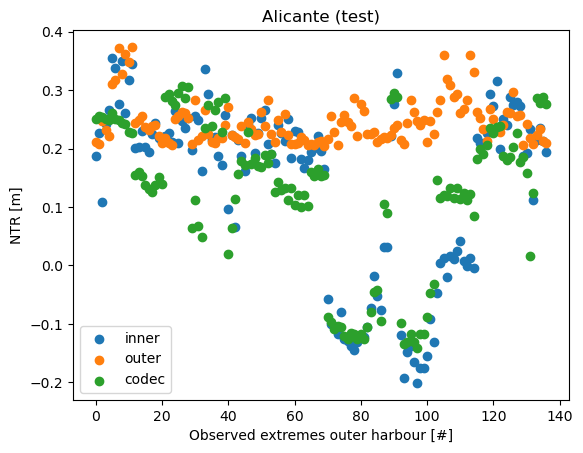

In [11]:
plt.figure()
plt.scatter(np.arange(len(alic2_test_extremes.date)),alic2_test_extremes.surge,label='inner')
plt.scatter(np.arange(len(alic2_test_extremes.date)),lstms.o.sel(split='test').isel(it=0,tg=0).sel(time=alic2_test_extremes.date.values),label='outer')
plt.scatter(np.arange(len(alic2_test_extremes.date)),codec.surge.sel(time=alic2_test_extremes.date.values).sel(split='test'),label='codec')
plt.legend()
plt.title('Alicante (test)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')

Text(0, 0.5, 'NTR [m]')

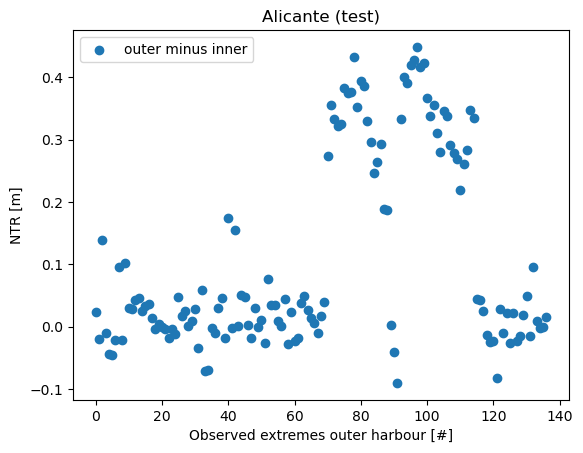

In [12]:
plt.figure()
plt.scatter(np.arange(len(alic2_test_extremes.date)),lstms.o.sel(split='test').isel(it=0,tg=0).sel(time=alic2_test_extremes.date.values)-alic2_test_extremes.surge,label='outer minus inner')

plt.legend()
plt.title('Alicante (test)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')

Text(0, 0.5, 'NTR [m]')

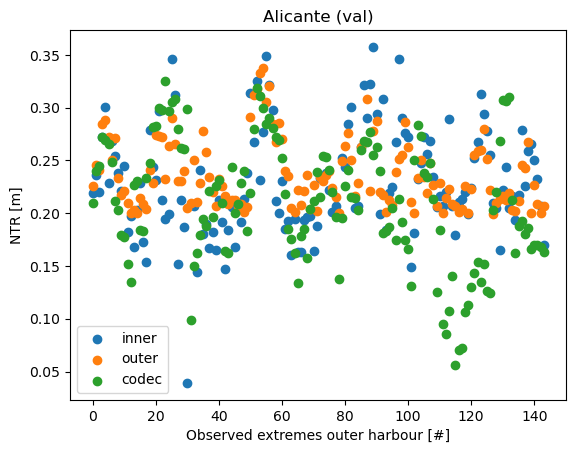

In [13]:
plt.figure()
plt.scatter(np.arange(len(alic2_val_extremes.date)),alic2_val_extremes.surge,label='inner')
plt.scatter(np.arange(len(alic2_val_extremes.date)),lstms.o.sel(split='val').isel(it=0,tg=0).sel(time=alic2_val_extremes.date.values),label='outer')
plt.scatter(np.arange(len(alic2_val_extremes.date)),codec.surge.sel(time=alic2_val_extremes.date.values).sel(split='val'),label='codec')
plt.legend()
plt.title('Alicante (val)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')


Text(0, 0.5, 'NTR [m]')

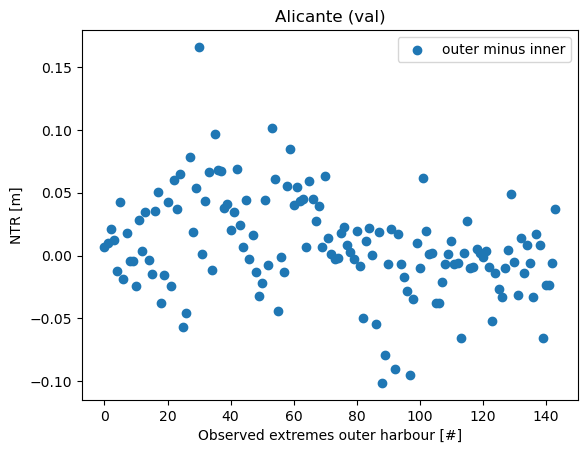

In [14]:
plt.figure()
plt.scatter(np.arange(len(alic2_val_extremes.date)),lstms.o.sel(split='val').isel(it=0,tg=0).sel(time=alic2_val_extremes.date.values)-alic2_val_extremes.surge,label='outer minus inner')

plt.legend()
plt.title('Alicante (val)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')
